In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('../input/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [3]:
test_df = pd.read_csv('../input/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


9, 4, 0, 8, 7, 0, 4, 6


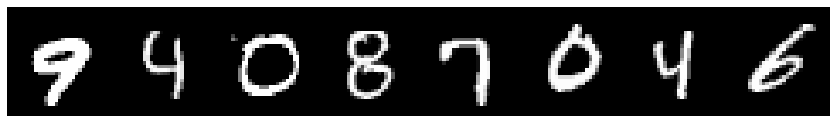

In [5]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

### Histogram of the classes

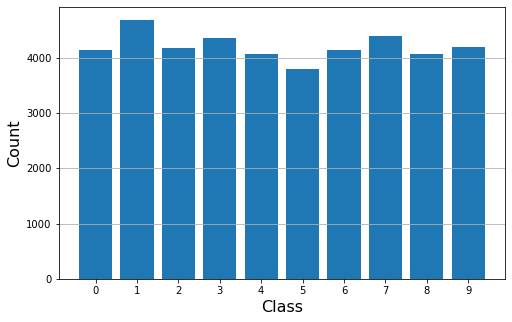

In [6]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

## Data Loader

In [7]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [28]:
batch_size = 64

train_dataset = MNIST_data('../input/train.csv')
test_dataset = MNIST_data('../input/test.csv')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

## Network Structure

In [29]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [30]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [31]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))

In [22]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

### Train the network

Reaches 0.995 accuracy on test set after 50 epochs

In [ ]:
n_epochs = 3

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.006646
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.094695
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.300392
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.098371


## Prediction on Test Set

In [33]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [34]:
test_pred = prediciton(test_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [35]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [36]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [37]:
out_df.to_csv('submission.csv', index=False)